In [1]:
##############################################################################
#
# Supplemental Matlab code for Exercise 4.6 in the book
#
# Simo Sarkka (2013), Bayesian Filtering and Smoothing,
# Cambridge University Press. 
#
# Last updated: $Date: 2013/08/26 12:58:41 $
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.
#
##############################################################################

In [2]:
import numpy as np
from numpy import matrix, sin, cos
from numpy.linalg import cholesky, inv
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os, sys
sys.path.append('../EKFUKF_Py/')

import lti_disc, gauss_rnd, kf_predict, kf_update, rts_smooth

In [3]:
##############################################################################
# Generate data ##############################################################
##############################################################################

# Lock random seed
# np.random.seed(123)

# Gaussian ranom draw, m is the mean and S the covariance
gauss_rnd = lambda m, S: m.T + cholesky(S) @ np.random.normal(size=len(m))

# Calculate root mean squared error
rmse = lambda x, y: np.sqrt(np.mean((x-y)**2))

In [4]:
# Define parameters
steps = 100  # Number of time steps
w     = 0.5  # Angular velocity
q     = 0.01 # Process noise spectral density
r     = 0.1  # Measurement noise variance

In [5]:
# This is the transition matrix
A = np.array([[cos(w), sin(w)/w], [-w*sin(w), cos(w)]])

# This is the process noise covariance
Q = np.array([[0.5*q*(w-cos(w)*sin(w))/w**3, 0.5*q*sin(w)**2/w**2],
              [0.5*q*sin(w)**2/w**2,   0.5*q*(w+cos(w)*sin(w))/w]])

In [6]:
# Simulate data
X = np.zeros((steps, 2))    # The true signal
Y = np.zeros(steps)         # Measurements
T = np.arange(1, steps+1)   # Time

x = np.array([0, 0.1])      # True initial value
for k in range(steps):
    x = gauss_rnd(A@x, Q)
    y = gauss_rnd(matrix(x[0]), matrix(r))
    X[k] = x
    Y[k] = y

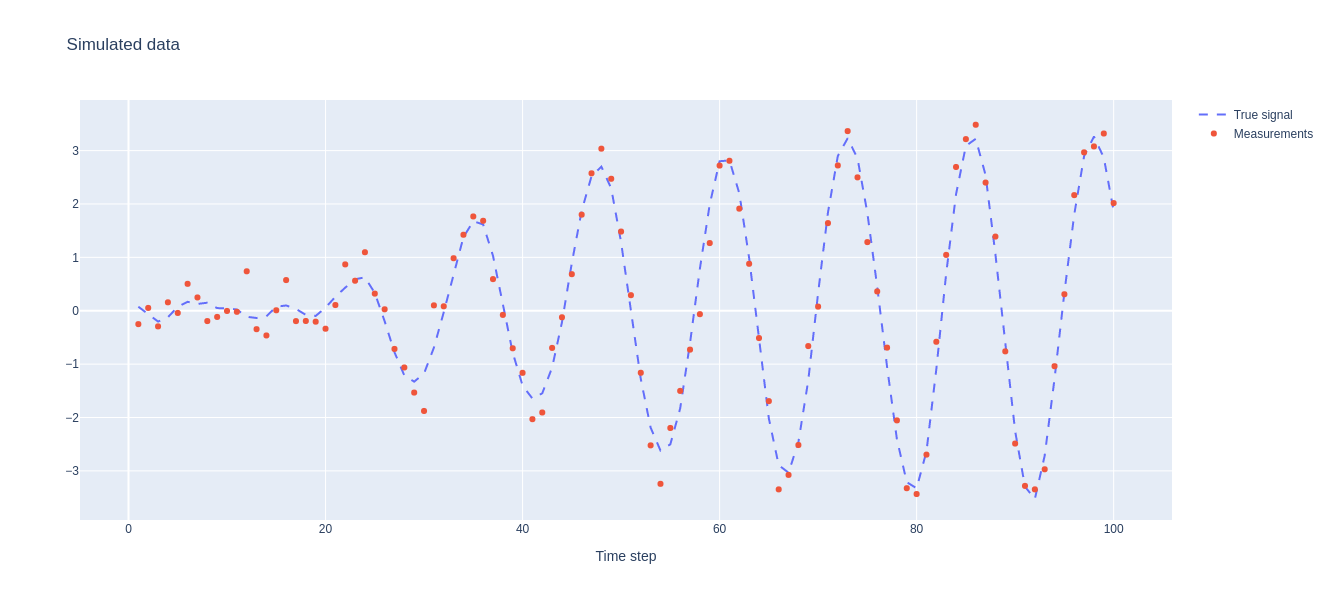

In [7]:
# Visualize
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0], line_dash='dash', name='True signal')
fig.add_scatter(x=T, y=Y, mode='markers', name='Measurements')
fig.layout.update(title='Simulated data', xaxis_title='Time step', height=600)
fig.show()

This is the simulated data.

In [8]:
##############################################################################
# Baseline solution ##########################################################
##############################################################################

# Baseline solution. The estimates of x_k are stored as columns of
# the matrix EST1.

# Calculate baseline estimate
m1 = np.array([0., 1.])  # Initialize first step with a guess
EST1 = np.zeros((steps, 2))
for k in range(steps):
    m1[1] = Y[k]-m1[0]
    m1[0] = Y[k]
    EST1[k] = m1

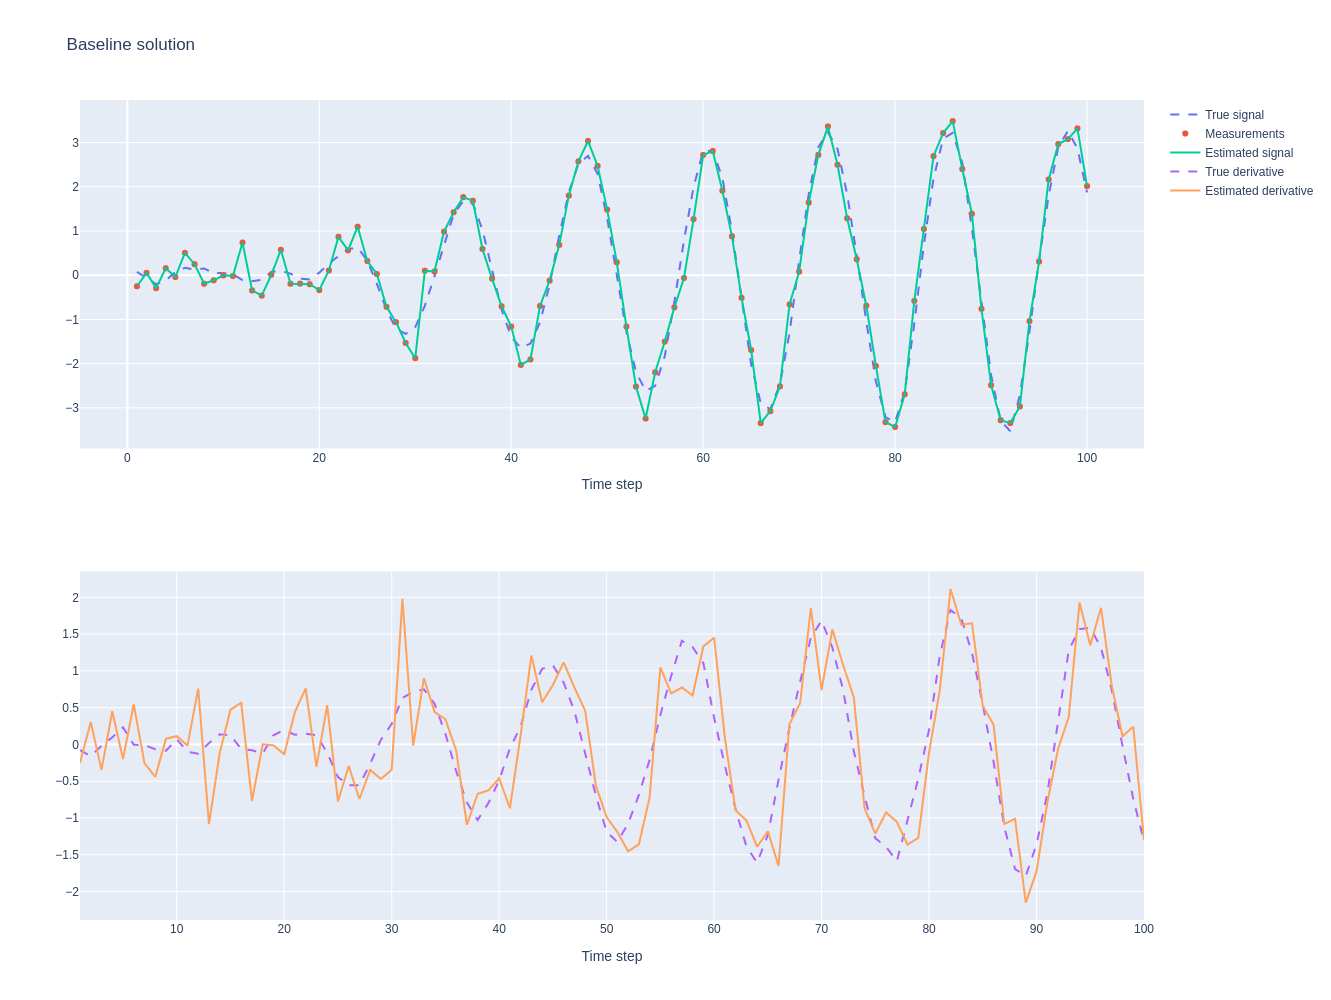

In [9]:
# Visualize results
fig = go.Figure(make_subplots(rows=2, cols=1))
#Plot the signal and its estimate
fig.add_scatter(x=T, y=X[:,0], line_dash='dash', name='True signal', row=1, col=1)
fig.add_scatter(x=T, y=Y, mode='markers', name='Measurements', row=1, col=1)
fig.add_scatter(x=T, y=EST1[:,0], name='Estimated signal', row=1, col=1)
#Plot the derivative and its estimate
fig.add_scatter(x=T, y=X[:,1], line_dash='dash', name='True derivative', row=2, col=1)
fig.add_scatter(x=T, y=EST1[:,1], name='Estimated derivative', row=2, col=1)
fig.layout.update(title='Baseline solution', xaxis_title='Time step', xaxis2_title='Time step', height=1000)
fig.show()

In [10]:
#Compute error
err1 = rmse(X,EST1)
err1

0.40626122063279146

This is the base line estimate.

In [11]:
##############################################################################
# Kalman filter ##############################################################
##############################################################################
  
# Kalman filter solution. The estimates
# of x_k are stored as columns of
# the matrix EST2.

m2 = np.array([0,1]).reshape(2,1)  # Initialize first step
P2 = np.eye(2)                     # Some uncertanty in covariance  
EST2 = np.zeros((steps,2,1))         # Allocate space for results

H = np.matrix([1,0])
R = np.matrix(0.1)

# Run Kalman filter
for k in range(steps):
    m2, P2 = kf_predict.kf_predict(m2, P2, A, Q)
    m2, P2, *_ = kf_update.kf_update(m2, P2, Y[k], H, R)

    # Store the results
    EST2[k] = m2

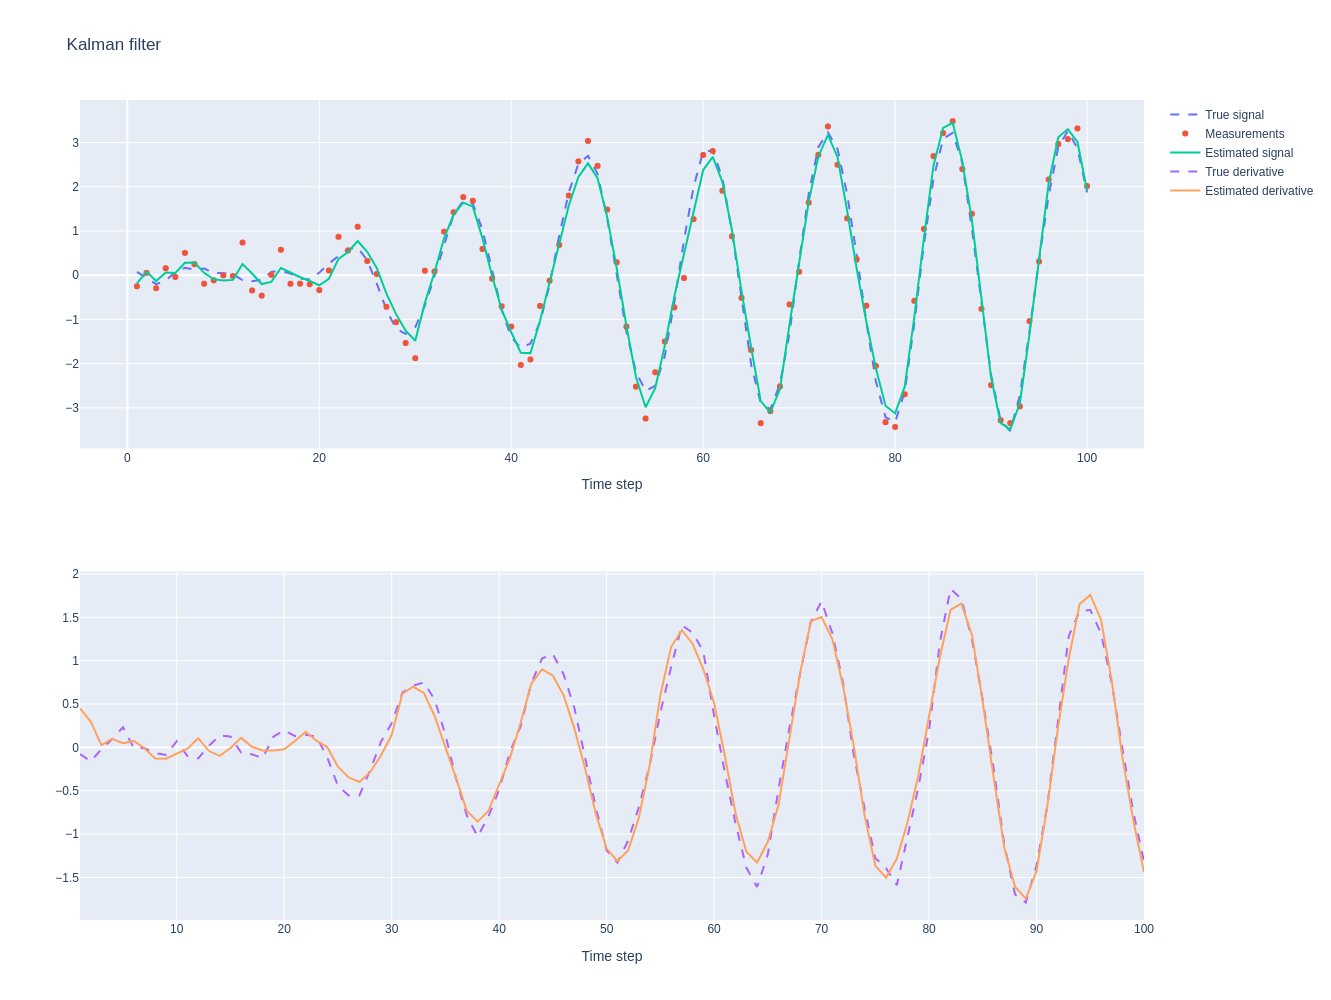

In [12]:
# Visualize results
fig = go.Figure(make_subplots(rows=2, cols=1))
#Plot the signal and its estimate
fig.add_scatter(x=T, y=X[:,0], line_dash='dash', name='True signal', row=1, col=1)
fig.add_scatter(x=T, y=Y, mode='markers', name='Measurements', row=1, col=1)
fig.add_scatter(x=T, y=EST2[:,0,0], name='Estimated signal', row=1, col=1)
#Plot the derivative and its estimate
fig.add_scatter(x=T, y=X[:,1], line_dash='dash', name='True derivative', row=2, col=1)
fig.add_scatter(x=T, y=EST2[:,1,0], name='Estimated derivative', row=2, col=1)
fig.layout.update(title='Kalman filter', xaxis_title='Time step', xaxis2_title='Time step', height=1000)
fig.show()

In [13]:
# Compute error
err2 = rmse(X,EST2[:,[0,1],0])
err2

0.17426630866087453

This will be the KF estimate.

In [14]:
##############################################################################
# Stationary Kalman filter solution ##########################################
##############################################################################

# The estimates of x_k are stored as columns of
# the matrix EST3.

m3 = np.array([0, 1]).reshape(2,1)     # Initialize first step
P3 = np.eye(2)             # Some uncertanty in covariance  
K  = np.array([0, 0]).reshape(2,1)       # Store the stationary gain here  
EST3 = np.zeros((steps,2,1))   # Allocate space for results

for k in range(steps):
    # Replace these with the stationary Kalman filter equations
    m3 = A@m3 + A@K@(y-H@m3)
    S = H@P3@H.T + R
#     P3 = A@P3@A.T + Q - A@K@H@P3@A.T
    P3 = A@P3@A.T + Q - A@P3@H.T @ inv(S) @ H@P3@A.T
    K = P3 @ H.T @ inv(S)
    
    # Store the results
    EST3[k] = m3

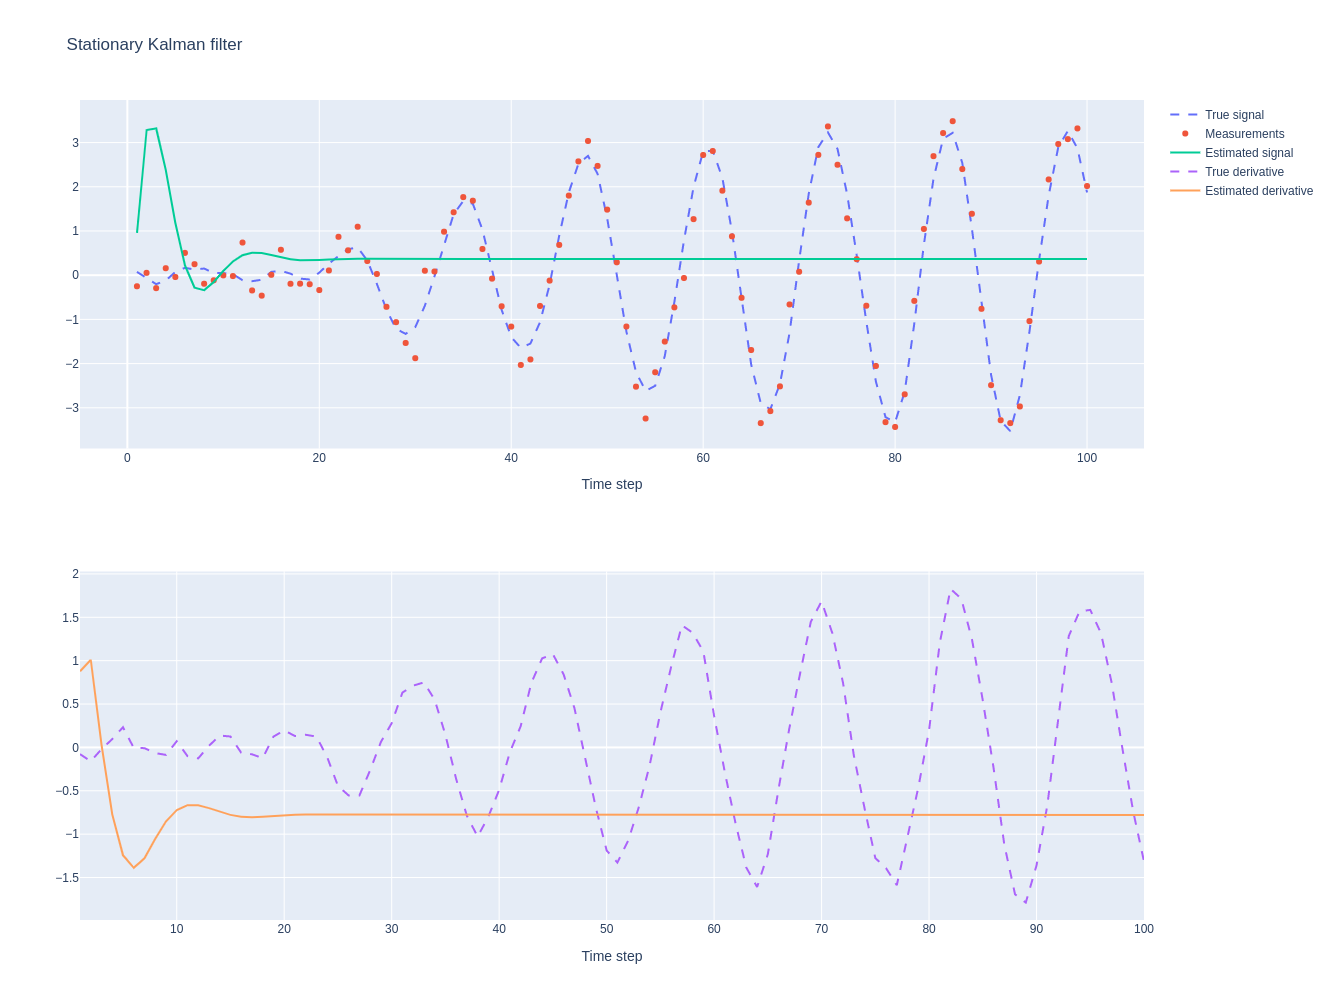

In [15]:
# Visualize results
fig = go.Figure(make_subplots(rows=2, cols=1))
#Plot the signal and its estimate
fig.add_scatter(x=T, y=X[:,0], line_dash='dash', name='True signal', row=1, col=1)
fig.add_scatter(x=T, y=Y, mode='markers', name='Measurements', row=1, col=1)
fig.add_scatter(x=T, y=EST3[:,0,0], name='Estimated signal', row=1, col=1)
#Plot the derivative and its estimate
fig.add_scatter(x=T, y=X[:,1], line_dash='dash', name='True derivative', row=2, col=1)
fig.add_scatter(x=T, y=EST3[:,1,0], name='Estimated derivative', row=2, col=1)
fig.layout.update(title='Stationary Kalman filter', xaxis_title='Time step', xaxis2_title='Time step', height=1000)
fig.show()

In [16]:
# Compute error
err3 = rmse(X,EST3[:,[0,1],0])
err3

1.5558289422343434

This will be the SKF estimate.